# Demonstrate membership inference attacks on means by test statistics

## Tuneable simulation parameters

In [24]:
import numpy as np
from scipy import stats
import math
np.random.seed(123) # might want to change while testing to make sure you're getting the same results (no variation by sampling)

## PARAMETERS
n_sims = 10000
n_samples = 10
k_attributes = 100

## Define utility functions for simulating data and calculating the test statistics

In [25]:
def synthesize(population_prob, n=1):
    """Utility function to simulate sampling from a population.
    Each column is sampled with the coin-flip probability defined in population_prob."""
    x = np.random.binomial(n=1, p=population_prob, size=(n, len(population_prob)))
    #x[x == 0] = -1  # Sometimes it is convenient in ML to recode as {-1,1}
    return x


## TEST STATISTICS
def test_homer(alice, sample_mean, population_mean):
    """Calculates the Homer test statistic"""
    # sum(|y-p| - |y-a|) --> a different test statistic than the one from slides but same effect
    # doesn't take into account direction only amount
    test_statistic = sum(abs(alice - population_mean) - abs(alice - sample_mean))
    return test_statistic


def test_dwork(alice, sample_mean, population_mean):
    """Calculates the Dwork et al. test statistic using the population means
    Let `population_mean=referent` if using only a single individual from the population as a referent.
    """
    # <y-p, a-p>
    test_statistic = np.dot(sample_mean-population_mean, alice-population_mean)
    return test_statistic


def null_distribution(fun, population_prob, population_mean, null_sims=1000, alpha=0.05):
    """Simulates the null distribution"""
    # A null distribution and critical value generator
    hold = []

    for i in range(null_sims):
        sample_mean = synthesize(population_prob, n=n_samples).mean(axis=0)
        null_alice = synthesize(population_prob)[0]
        # referent = synthesize(population_prob)[0]

        hold.append(fun(null_alice, sample_mean, population_mean))

    null_dist_vals = np.sort(hold)[::-1]
    return {
        "nulldist": null_dist_vals,
        "critical_val": null_dist_vals[round(alpha*len(null_dist_vals))] # T; delta if value; what we need to reject the null
        # for example, we want to make sure that our guy is more likely (larger) than 90% of distribution values
        # Since we have sorted them already, we can just take the value in that position of the array and return
    }

## Simple graph function for showing the distribution, partitioned by critical value

In [26]:
import matplotlib.pyplot as plt


def show_distribution(x, critical_value, title):
    """Visualize the distribution with a density plot"""

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
    kernel = stats.gaussian_kde(x)
    support = np.linspace(min(x) - kernel.factor, max(x) + kernel.factor, num=500)
    densities = kernel(support)

    flag = support < critical_value
    max_density = max(densities)

    plt.fill_between(support[flag], densities[flag], color='#005aef80')
    plt.fill_between(support[~flag], densities[~flag], color='#ef5c0080')
    plt.axvline(x=critical_value)
    plt.text(x=critical_value, y=0.8*max_density, s=" OUT", horizontalalignment='left')
    plt.text(x=critical_value, y=0.8*max_density, s="IN ", horizontalalignment='right')
    plt.text(x=critical_value, y=0.7*max_density, s=f' {(x > critical_value).mean():.2}', horizontalalignment='left')
    plt.title(title)
    plt.xlabel("Test Statistic")
    plt.ylabel("Density")
    plt.show()

## Simulate and graph a null distribution

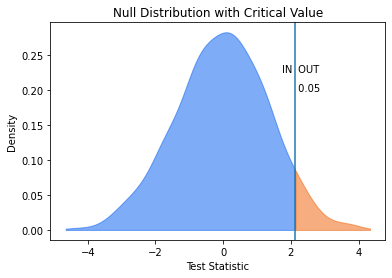

In [27]:
# Generate underlying population attributes
population_prob = np.random.uniform(size=k_attributes)
population_mean = population_prob 
# population_mean = 2*population_prob - 1.  # If we are recoding to {-1,1} in next function

# Find the null distribution
output = null_distribution(test_homer, population_prob, population_mean)
testdist = output["nulldist"]
criticalValue = output["critical_val"]
show_distribution(testdist, criticalValue, title="Null Distribution with Critical Value")
plt.show()

## Here is our core simulation.  We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

In [28]:
## SIMULATE 

# of length n_sims, with 4 values in each
history = np.zeros(shape=(n_sims, 4))

alpha = 0.01
# Find null distributions
nullDist_Homer = null_distribution(test_homer, population_prob, population_mean, alpha=alpha)
nullDist_Dwork = null_distribution(test_dwork, population_prob, population_mean, alpha=alpha)

for i in range(n_sims):
    # Simulate data
    sample = synthesize(population_prob, n=n_samples)
    sample_mean = sample.mean(axis=0)
    alice = sample[0]
    null_alice = synthesize(population_prob, n=1)[0]
    # referent = synthesize(population_prob, n=1)[0]

    # Store simulated values
    history[i, :] = [
        # homer statistics
        test_homer(alice=alice, sample_mean=sample_mean, population_mean=population_mean), 
        test_homer(alice=null_alice, sample_mean=sample_mean, population_mean=population_mean), 

        # dwork statistics
        test_dwork(alice=alice, sample_mean=sample_mean, population_mean=population_mean), 
        test_dwork(alice=null_alice, sample_mean=sample_mean, population_mean=population_mean)
    ]

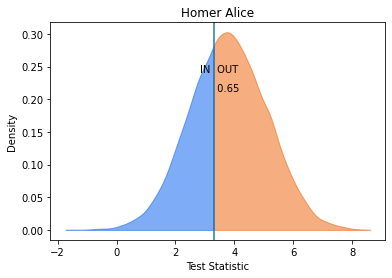

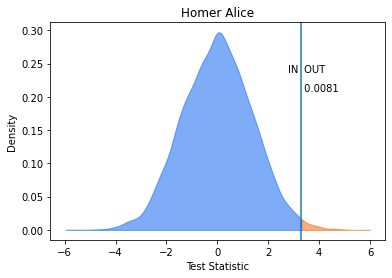

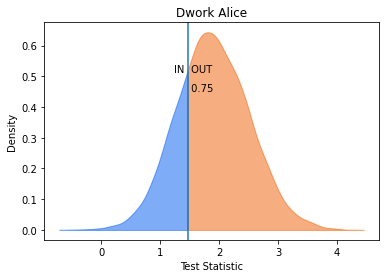

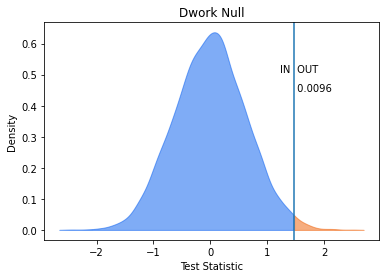

In [29]:
show_distribution(history[:, 0], critical_value=nullDist_Homer["critical_val"], title="Homer Alice")
show_distribution(history[:, 1], critical_value=nullDist_Homer["critical_val"], title="Homer Alice")

show_distribution(history[:, 2], critical_value=nullDist_Dwork["critical_val"], title="Dwork Alice")
show_distribution(history[:, 3], critical_value=nullDist_Dwork["critical_val"], title="Dwork Null")

# Tvalue = math.sqrt(8 * k_attributes * math.log(1 / alpha))
# ax1.avxline(Tvalue, color="red")
# ax2.avxline(Tvalue, color="red")

## We can expand this simulation by iterating across the number of features available

In [30]:
## SIMULATE WITH VARYING NUMBER OF FEATURES

# of length n_sims, with 4 values in each

log_seq = np.linspace(start=math.log10(10), stop=math.log10(500), num=15)
k_seq = (10**log_seq).astype(int)
print(k_seq)

all_history = np.zeros(shape=(len(k_seq), 3))

alpha = 0.01


for j, k_att in enumerate(k_seq):
    print(f"{j+1} of {len(k_seq)}: {k_att}")

    pop_prob = np.random.uniform(size=k_att)
    pop_mean = pop_prob
    #pop_mean = 2 * pop_prob - 1.  # If we are recoding to {-1,1} in next function

    # Find null distributions
    nullDist_Homer = null_distribution(test_homer, pop_prob, pop_mean, alpha=alpha)
    nullDist_Dwork = null_distribution(test_dwork, pop_prob, pop_mean, alpha=alpha)

    critical_value_Homer = nullDist_Homer["critical_val"]
    critical_value_Dwork = nullDist_Dwork["critical_val"]


    temp_history = np.zeros(shape=(n_sims, 2))

    for i in range(n_sims):
        # Simulate data
        sample = synthesize(population_prob=pop_prob, n=n_samples)
        sample_mean = sample.mean(axis=0)
        alice = sample[0]
        null_alice = synthesize(population_prob=pop_prob, n=1)[0]
        # referent = synthesize(population_prob=pop_prob, n=1)[0]

        # Store simulated values
        temp_history[i, :] = [
            # homer statistics
            test_homer(alice=alice, sample_mean=sample_mean, population_mean=pop_mean), 
            # dwork statistics
            test_dwork(alice=alice, sample_mean=sample_mean, population_mean=pop_mean) 
        ]

    homer_membership_success_rate = (temp_history[:,0] > critical_value_Homer).mean() 
    dwork_membership_success_rate = (temp_history[:,1] > critical_value_Dwork).mean()

    all_history[j, :] = [
        k_att,
        homer_membership_success_rate,
        dwork_membership_success_rate,
    ]


[ 10  13  17  23  30  40  53  70  93 123 163 216 285 378 499]
1 of 15: 10
2 of 15: 13
3 of 15: 17
4 of 15: 23
5 of 15: 30
6 of 15: 40
7 of 15: 53
8 of 15: 70
9 of 15: 93
10 of 15: 123
11 of 15: 163
12 of 15: 216
13 of 15: 285
14 of 15: 378
15 of 15: 499


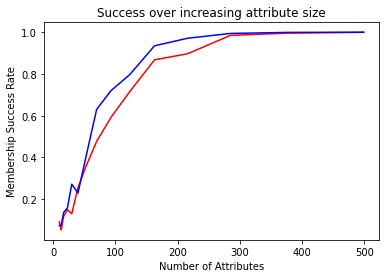

In [31]:
plt.plot(all_history[0:len(k_seq),0], all_history[0:len(k_seq),1], color="red") #homer
plt.plot(all_history[0:len(k_seq),0], all_history[0:len(k_seq),2], color="blue") #dwork
plt.xlabel("Number of Attributes")
plt.ylabel("Membership Success Rate")
plt.title("Success over increasing attribute size")
plt.show()